In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../setup/')
from torch_nl3rSetup import *
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, LinearLR
from torch.utils.data import DataLoader
import pandas as pd
import mvlearn
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_array, lil_array, coo_array

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

from sklearn.datasets import fetch_openml
from scipy.ndimage import rotate

import os 
import sys
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

device = torch.device(2)

%matplotlib inline
%config InlineBackend.figure_format='retina'

ModuleNotFoundError: No module named 'mvlearn'

In [38]:
mnist, mnist_labels = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [102]:
ones = mnist[mnist_labels == '3']
one_inds = np.argwhere(mnist_labels == '3').squeeze()

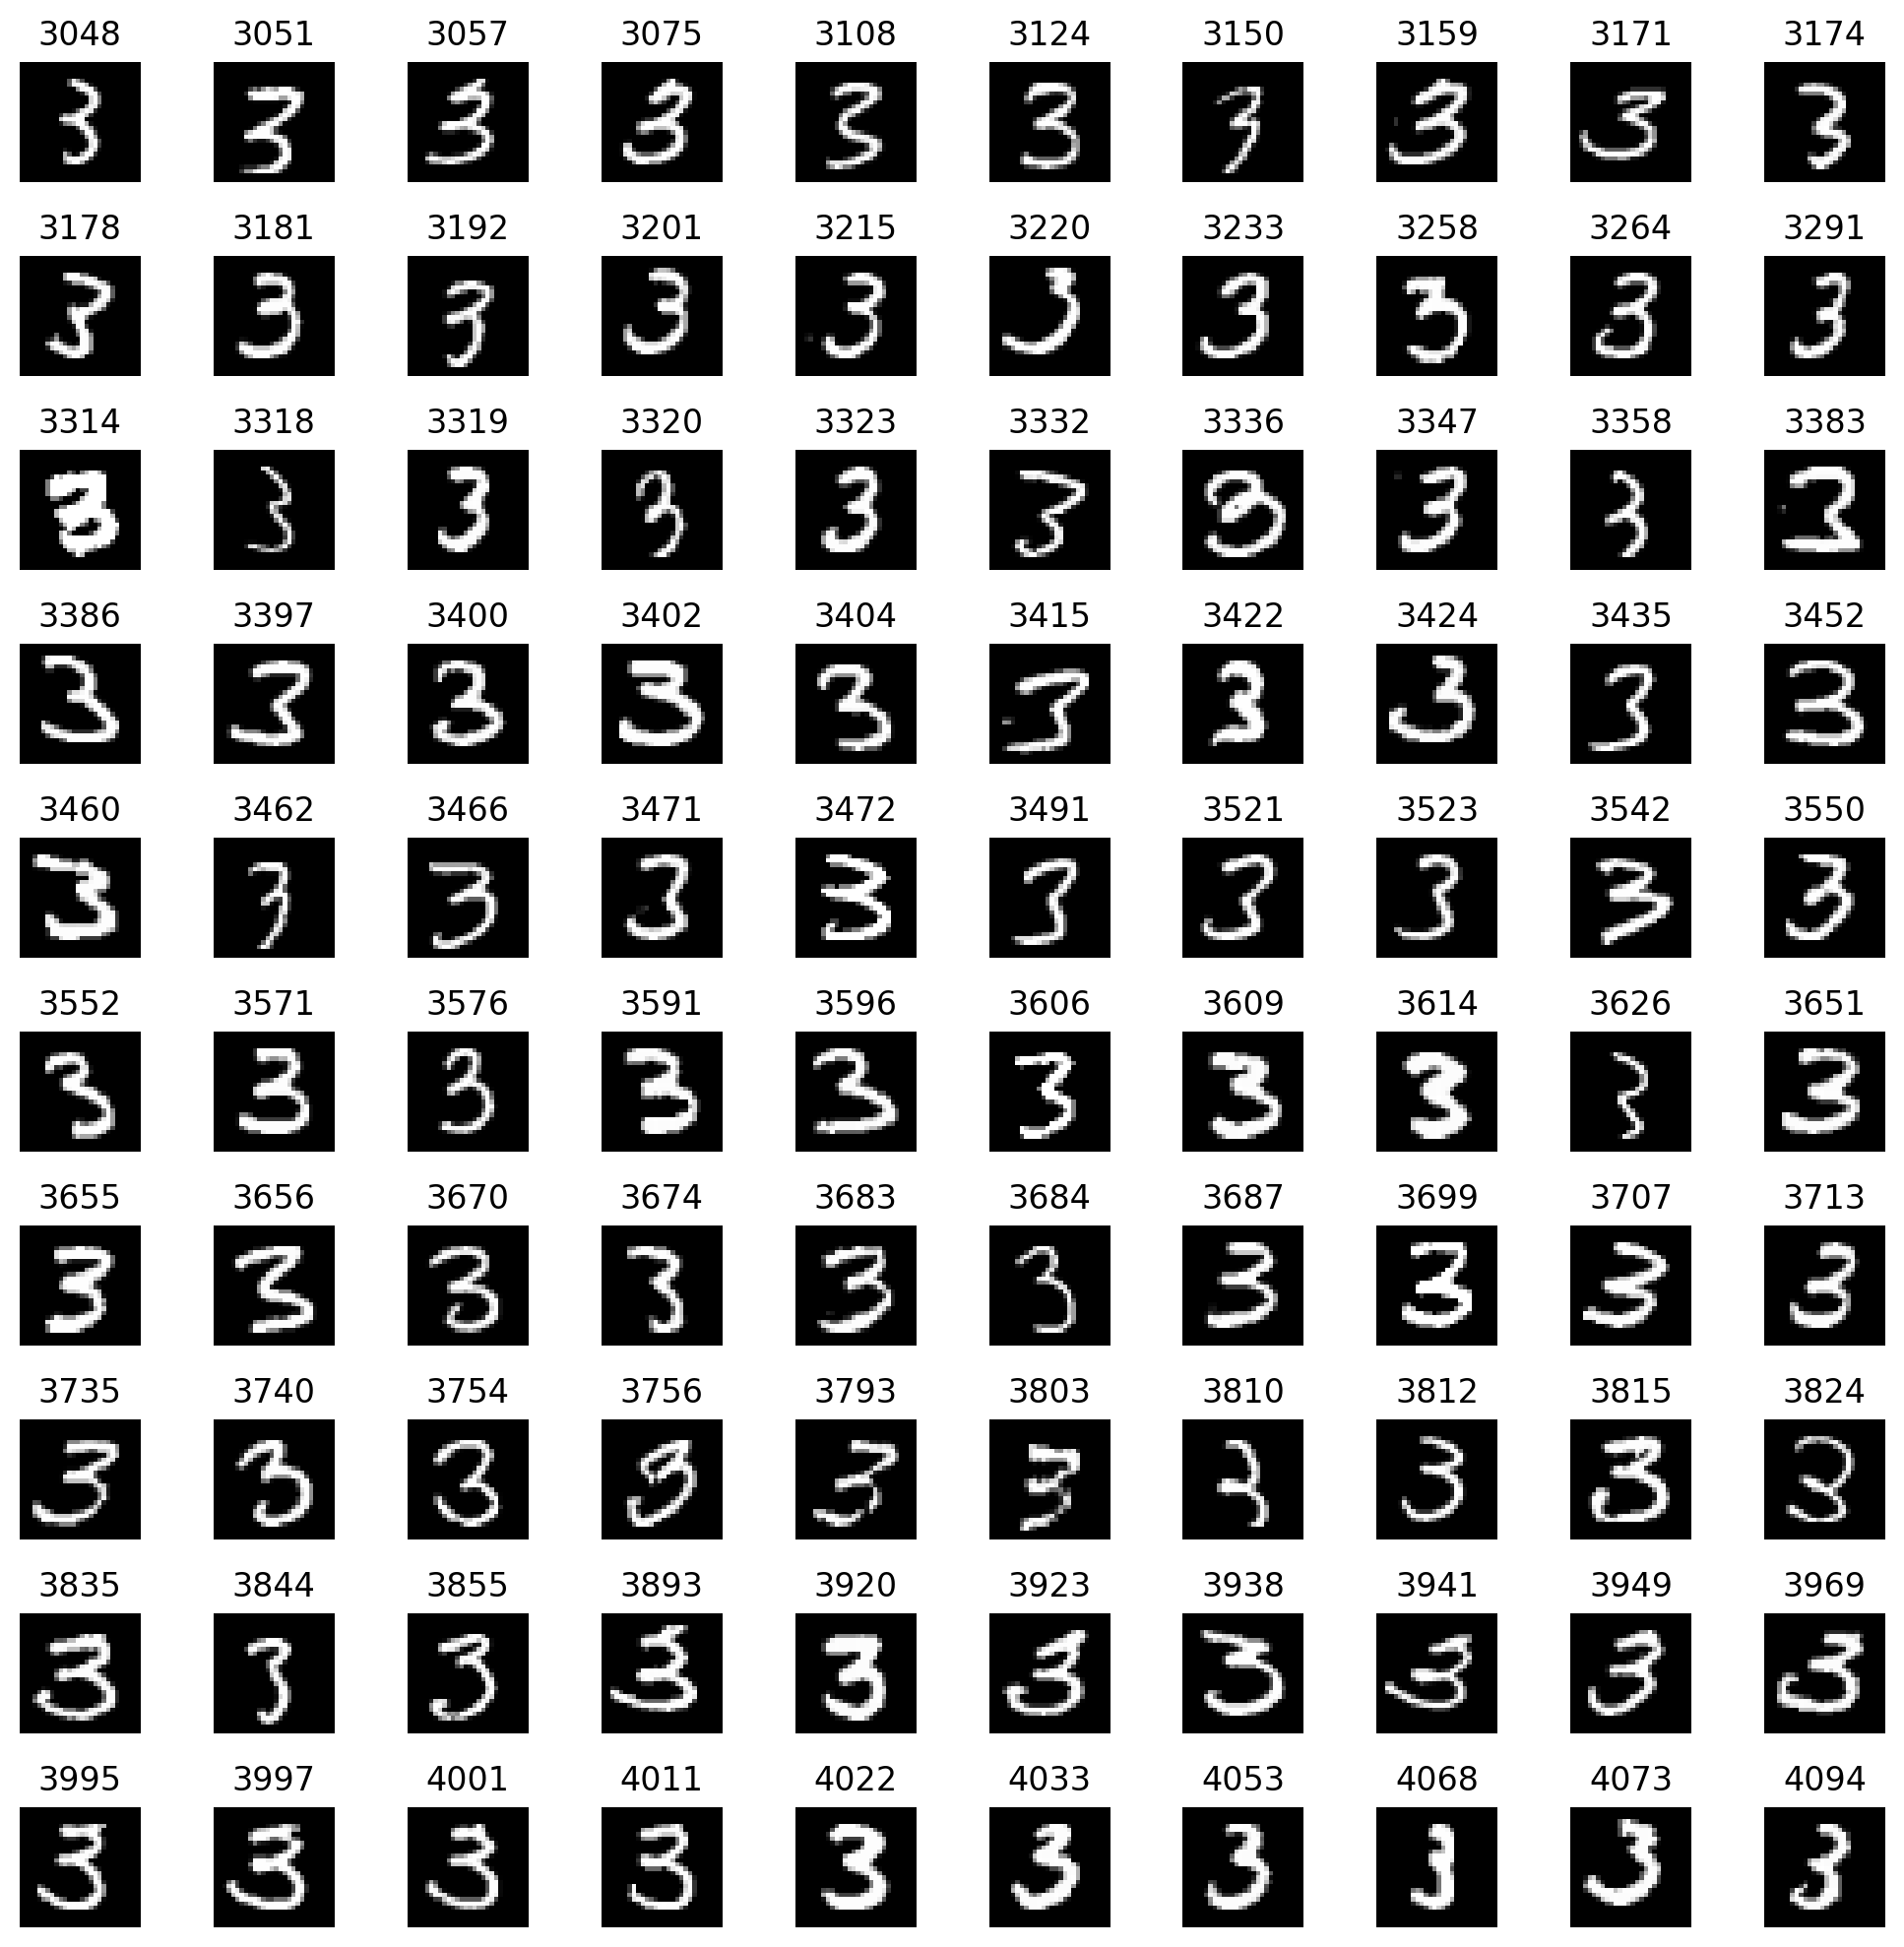

In [103]:
plt.figure(figsize=(10, 10))

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(ones[300+i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(one_inds[300+i])

plt.tight_layout()

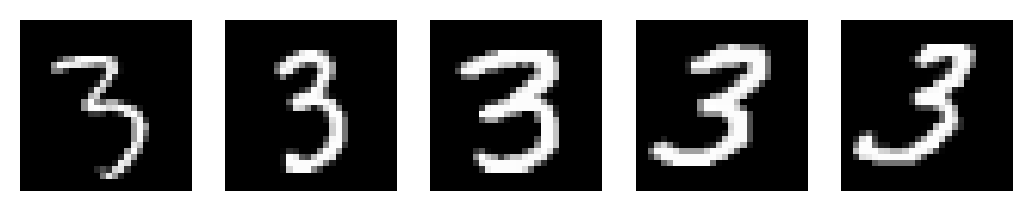

In [105]:
inset_inds = [2074, 98, 149, 135, 327]
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(mnist[inset_inds[i]].reshape(28, 28), cmap='gray')
    plt.axis('off'); 
    # plt.title(inset_inds[i]);

plt.savefig("inset_unrotated.svg", dpi=300, transparent=True)

In [58]:
mnist[inset_inds[i]].shape

(784,)

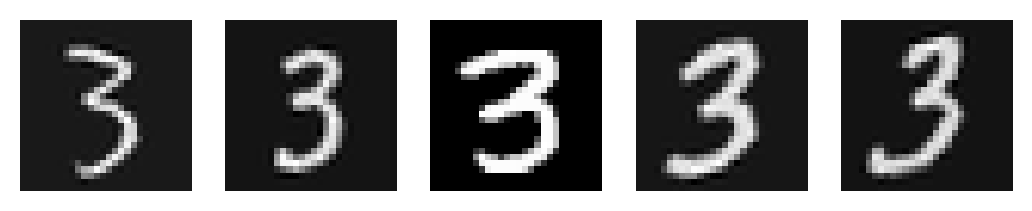

In [107]:
angles = [340, 350, 0, 15, 15]
inset_rotated = np.zeros((5, 784))
for i in range(5):
    inset_rotated[i,:], _ = rot_digit(mnist[inset_inds[i]], angles[i])

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(inset_rotated[i].reshape(28, 28), cmap='gray'); 
    plt.axis('off'); 
    # plt.title(angles[i])

plt.savefig("inset_rotated.svg", dpi=300, transparent=True)

In [108]:
inset = mnist[inset_inds]/255
inset_rotated = inset_rotated/255

In [109]:
inset = torch.Tensor(inset).to(device)
inset_rotated = torch.Tensor(inset_rotated).to(device)

inset_rotated[inset_rotated > 1] = 1
inset_rotated[inset_rotated < 0] = 0


In [110]:
z_s_x, z_s_y, z_y_inset, m_s_x, x_hat, y_hat = model(inset, inset_rotated)

In [111]:
x_hat = x_hat.cpu().detach().numpy()
y_hat = y_hat.cpu().detach().numpy()
inset = inset.cpu().detach().numpy()
inset_rotated = inset_rotated.cpu().detach().numpy()

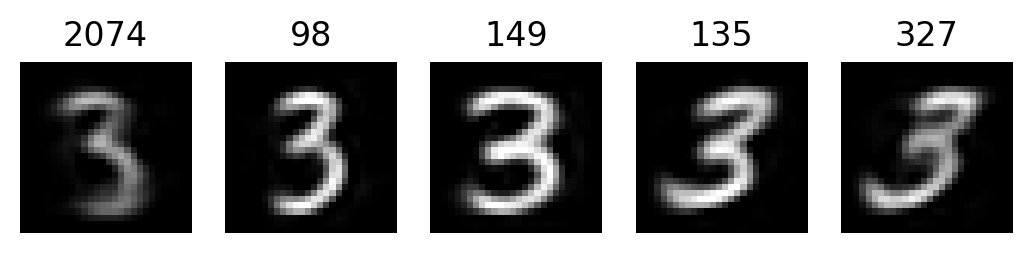

In [112]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_hat[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1);
    plt.axis('off'); plt.title(inset_inds[i])

In [7]:
def rot_digit(m, angle=-1):
    """
    Returns the digit/image "m" by a random angle [-45,45]deg
    clips it to MNIST size
    and returns it flattened into (28*28,) shape
    """
    if angle < 0:
        angle=np.random.rand()*360 #will lead to ambiguities because "6" = "9"

    m = m.reshape((28,28))
    tmp = rotate(m, angle=angle)
    xs, ys = tmp.shape
    xs = int(xs/2)
    ys = int(ys/2)
    rot_m = tmp[xs-14:xs+14,ys-14:ys+14]
    return rot_m.reshape((28*28,)), angle

In [113]:
# generate rotated digits
rotated_mnist = np.zeros_like(mnist)
angles = np.zeros(mnist.shape[0], dtype="float32")

for i in range(mnist.shape[0]):
    rotated_mnist[i], angles[i] = rot_digit(mnist[i])

rotated_mnist = rotated_mnist.astype("int").astype("float32")
rotated_mnist[rotated_mnist < 0] = 0
rotated_mnist[rotated_mnist > 255] = 255

In [12]:
def carlosPlus(x, logof2=np.log(2)):
    return 2*(F.softplus(x) - logof2)

# decoder is the same as encoder but doesn't apply the nonlinearity to the final output
class encoder(nn.Module):
    def __init__(self, nInputs, nOutputs, layers=None):
        super(encoder, self).__init__()
        self.layers = nn.ModuleList()
        if layers:
            self.layers.append(nn.Linear(nInputs, layers[0]))
            # self.layers.append(nn.Dropout(p=0.2))
            for i in range(len(layers)-1):
                self.layers.append(nn.Linear(layers[i], layers[i+1]))
                # self.layers.append(nn.Dropout(p=0.2))
            self.layers.append(nn.Linear(layers[-1], nOutputs))
        
    def forward(self, x):
        for layer in self.layers:
            x = carlosPlus(layer(x), np.log(2))
            # x = F.relu(layer(x))
        return x
    
class decoder(nn.Module):
    def __init__(self, nInputs, nOutputs, layers=None, sig=False):
        super(decoder, self).__init__()
        self.layers = nn.ModuleList()
        self.sig = sig
        if layers:
            self.layers.append(nn.Linear(nInputs, layers[0]))
            # self.layers.append(nn.Dropout(p=0.2))
            for i in range(len(layers)-1):
                self.layers.append(nn.Linear(layers[i], layers[i+1]))
                # self.layers.append(nn.Dropout(p=0.2))
            self.layers.append(nn.Linear(layers[-1], nOutputs))
        
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i == len(self.layers)-1:
                if self.sig == True:
                    x = F.sigmoid(layer(x))
                else:
                    x = layer(x)
            else:
                x = carlosPlus(layer(x), np.log(2))
                # x = F.relu(layer(x))
        return x
    
class new_nl(nn.Module):
    def __init__(self, nInputs, nOutputs, nShared, nPrivSource, nPrivTarget, layers, layers_msr):
        super().__init__()
        # save params
        self.nInputs = nInputs
        self.nOutputs = nOutputs
        self.nShared = nShared
        self.nPrivSource = nPrivSource
        self.nPrivTarget = nPrivTarget

        # encoders
        # self.source_enc = encoder(self.nInputs, self.nPrivSource, layers)
        self.shared_source_enc = encoder(self.nInputs, self.nShared, layers)
        self.shared_target_enc = encoder(self.nOutputs, self.nShared, layers)
        self.target_enc = encoder(self.nOutputs, self.nPrivTarget, layers)
        
        # measurement networks
        self.msr_source = decoder(self.nPrivTarget, self.nShared, layers_msr[::-1])
        # self.msr_target = encoder(self.nPrivSource, self.nShared, layers_msr)
        # self.msr_source = decoder(self.nPrivTarget, self.nInputs, layers_msr[::-1])
        # self.msr_target = encoder(self.nPrivSource, self.nOutputs, layers_msr)
        
        # decoders
        self.source_dec = decoder(self.nPrivSource + self.nShared, self.nInputs, layers[::-1])
        self.target_dec = decoder(self.nShared + self.nPrivTarget, self.nOutputs, layers[::-1])

    def forward(self, x, y):
        # calculate latents
        # z_x = self.source_enc(x)
        z_s_x = self.shared_source_enc(x)
        z_s_y = self.shared_target_enc(y)
        z_y = self.target_enc(y)
        
        # estimate shared from private
        m_s_x = self.msr_source(z_y)
        # m_s_y = self.msr_target(z_x)
        
        # calculate reconstructions
        x_hat = self.source_dec(z_s_y)
        y_hat = self.target_dec(torch.hstack((z_s_x, z_y)))
        # y_hat = self.target_dec(torch.hstack((z_s_x, torch.zeros_like(z_y))))

        return z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat

In [13]:
nShared = 30
nInputs = 784
nOutputs = 784

layers = [256,128,64,32]

# ------------ train SPLICE --------------
# instantiate model + training"
model = new_nl(nInputs, nOutputs, nShared, 0, 2, layers, layers).to(device)
# model = new_conv(nInputs, nOutputs, nShared, 0, 2).to(device)

In [14]:
# model.load_state_dict(torch.load("mnist_model_old.pt"))
model.load_state_dict(torch.load("models/mnist/mnist_isomap_model_asymm.pt"))
# model.load_state_dict(torch.load("mnist_conv_model.pt"))
# model.load_state_dict(torch.load("mnist_model_asymm_big.pt"))

<All keys matched successfully>

In [20]:
X = (torch.Tensor(mnist[:33150]).to(device)/255)
Y = (torch.Tensor(rotated_mnist[:33150]).to(device)/255)

Y[Y > 255] = 255
Y[Y < 0] = 0

X_test = (torch.Tensor(mnist[33150:]).to(device)/255)
Y_test = (torch.Tensor(rotated_mnist[33150:]).to(device)/255)

Y_test[Y_test > 255] = 255
Y_test[Y_test < 0] = 0

# X = (torch.Tensor(mnist).to(device)/255).reshape(-1, 28, 28).unsqueeze(1)
# Y = (torch.Tensor(rotated_mnist).to(device)/255).reshape(-1, 28, 28).unsqueeze(1)

z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X_test, Y_test)
# z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X[-10000:], Y[-10000:])

In [89]:
X = (torch.Tensor(mnist[:60000]).to(device)/255)
Y = (torch.Tensor(rotated_mnist[:60000]).to(device)/255)

Y[Y > 255] = 255
Y[Y < 0] = 0

X_test = (torch.Tensor(mnist[60000:]).to(device)/255)
Y_test = (torch.Tensor(rotated_mnist[60000:]).to(device)/255)

Y_test[Y_test > 255] = 255
Y_test[Y_test < 0] = 0

# X = (torch.Tensor(mnist).to(device)/255).reshape(-1, 28, 28).unsqueeze(1)
# Y = (torch.Tensor(rotated_mnist).to(device)/255).reshape(-1, 28, 28).unsqueeze(1)

z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X_test, Y_test)
# z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X[-10000:], Y[-10000:])

In [22]:
torch.nn.functional.mse_loss(x_hat, X_test), torch.nn.functional.mse_loss(y_hat, Y_test)

(tensor(0.0270, device='cuda:2', grad_fn=<MseLossBackward0>),
 tensor(0.0266, device='cuda:2', grad_fn=<MseLossBackward0>))

In [90]:
x_hat = x_hat.detach().cpu().numpy().squeeze()
y_hat = y_hat.detach().cpu().numpy().squeeze()
z_y = z_y.detach().cpu().numpy().squeeze()

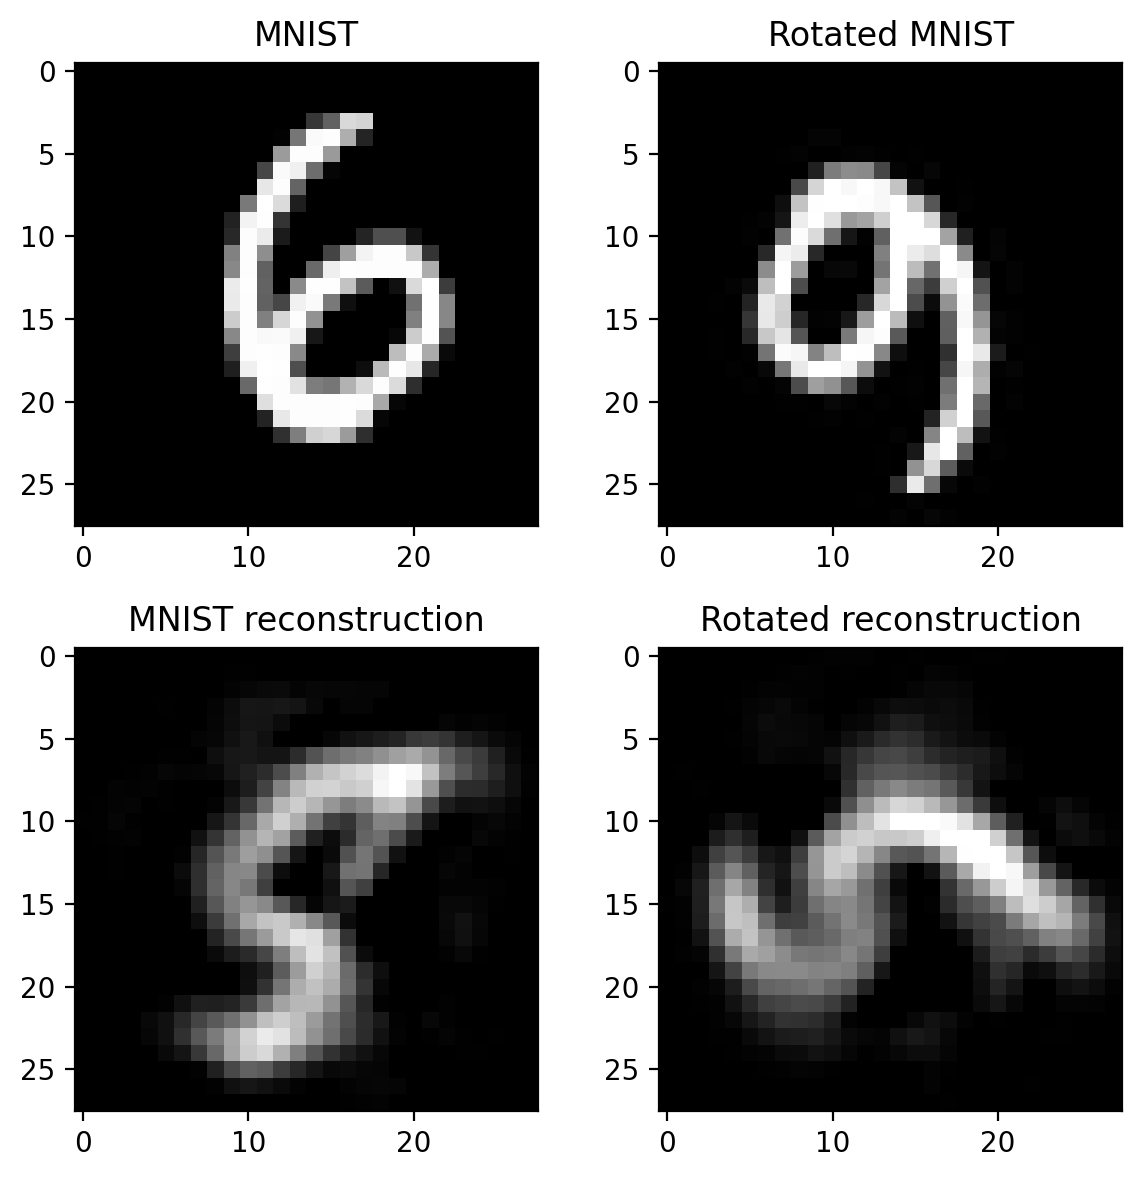

In [27]:
ind = 123
plt.figure(figsize=(6,6))

plt.subplot(2,2,1)
plt.imshow(mnist[ind].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
plt.title("MNIST")

plt.subplot(2,2,2)
plt.imshow(rotated_mnist[ind].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
plt.title("Rotated MNIST")

plt.subplot(2,2,3)
plt.imshow(x_hat[ind].reshape(28,28), cmap='gray', vmin=0, vmax=1) 
plt.title("MNIST reconstruction")

plt.subplot(2,2,4)
plt.imshow(y_hat[ind].reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.title("Rotated reconstruction"); 

plt.tight_layout()

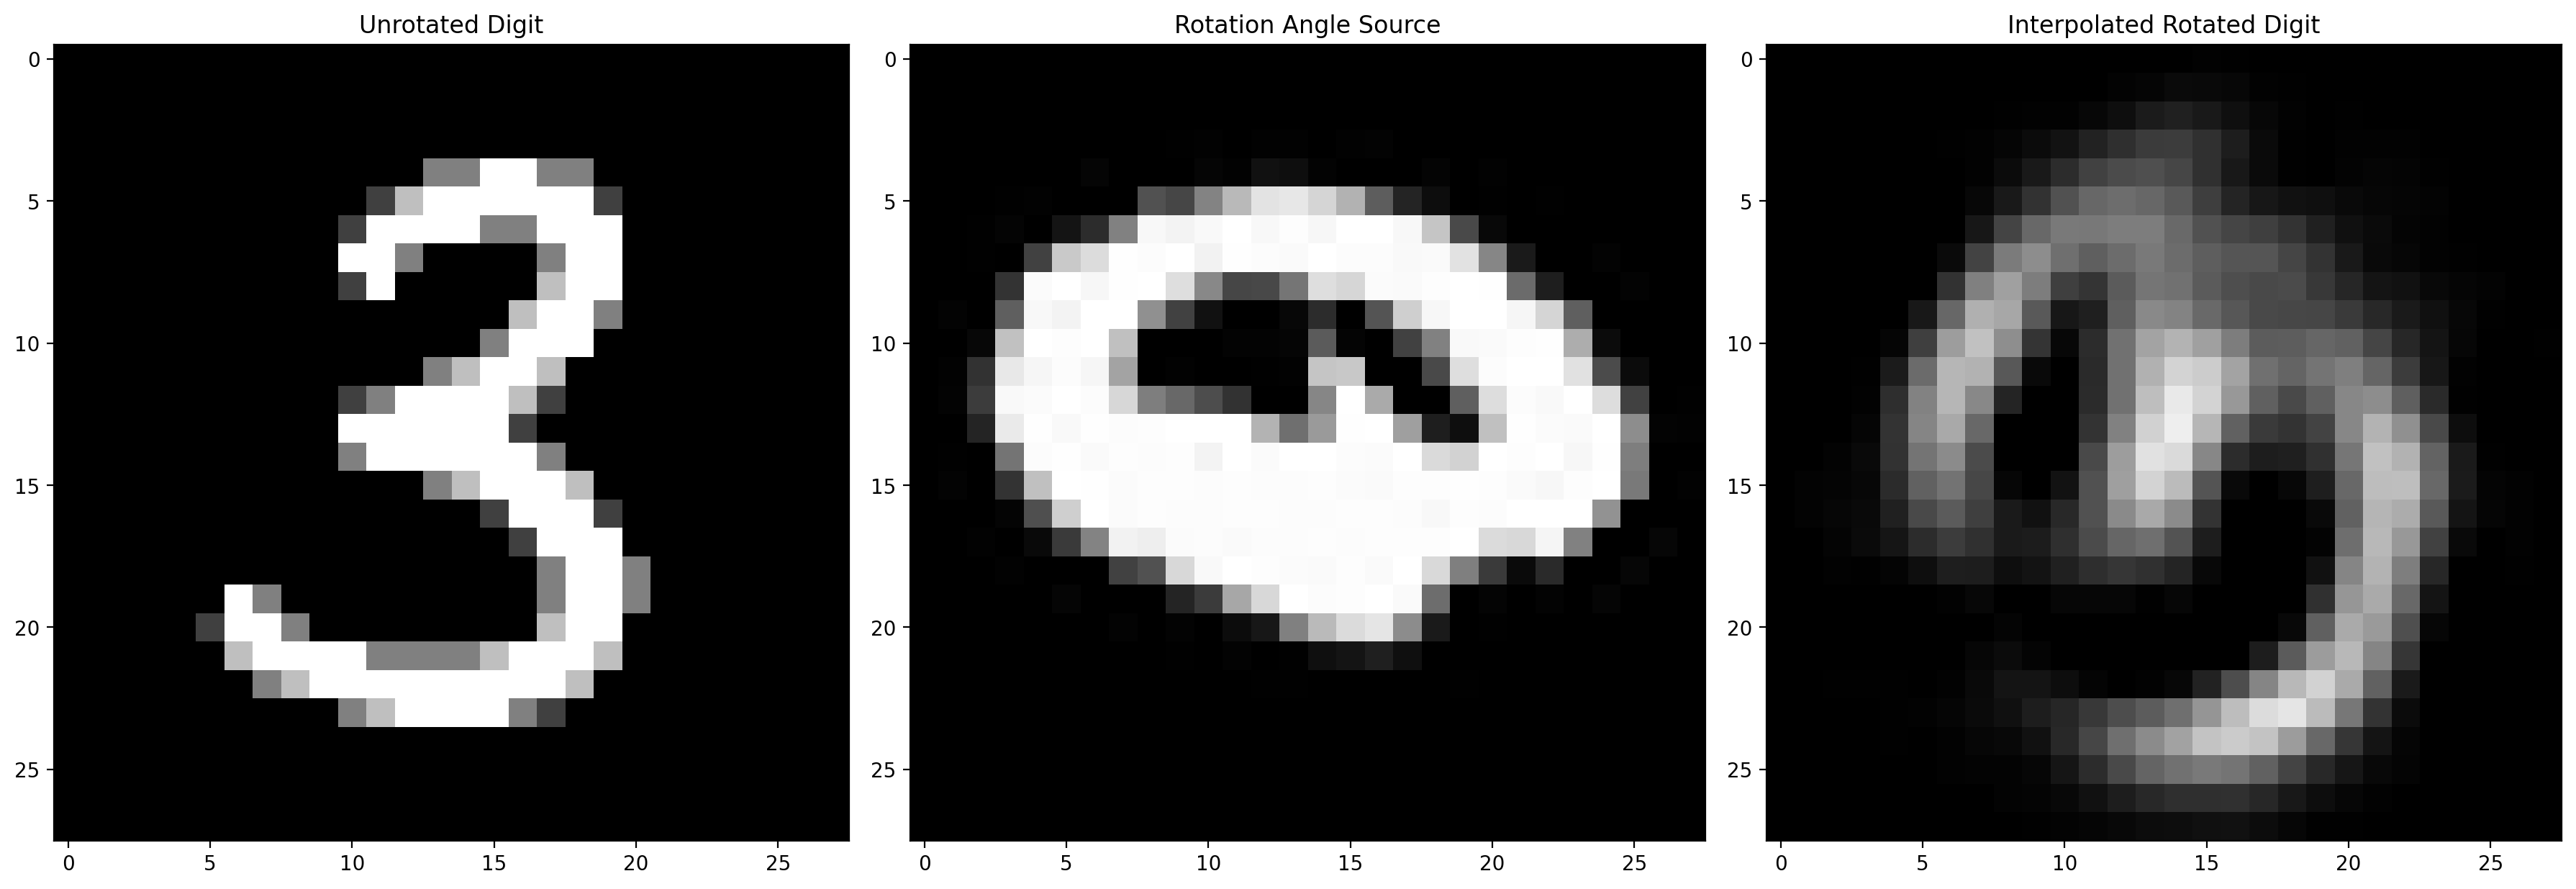

In [30]:
ind = 2230

test_rot_lat = torch.hstack((z_s_x[ind,:], z_y[-7]))
test_rot = model.target_dec(test_rot_lat).detach().cpu().numpy().reshape(28,28)

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(mnist[-10000:][ind].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
plt.title("Unrotated Digit")

# plt.subplot(1,4,2)
# plt.imshow(rotated_mnist[ind].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
# plt.title("Train Rotated Digit")

plt.subplot(1,3,3)
plt.imshow(test_rot, cmap='gray', vmin=0, vmax=1)
plt.title("Interpolated Rotated Digit")

plt.subplot(1,3,2)
plt.imshow(rotated_mnist[-10000:][-7].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
plt.title("Rotation Angle Source");
plt.tight_layout()

In [66]:
symmetric = [1,8]
asymmetric = [2,3,4,5,7,9]

In [86]:
# inds = np.arange(70000)[np.isin(mnist_labels.astype(int), asymmetric)]
inds = np.arange(0,60000)

In [28]:
mnist.shape[0] - 33150

8287

In [112]:
inds = np.arange(8287)

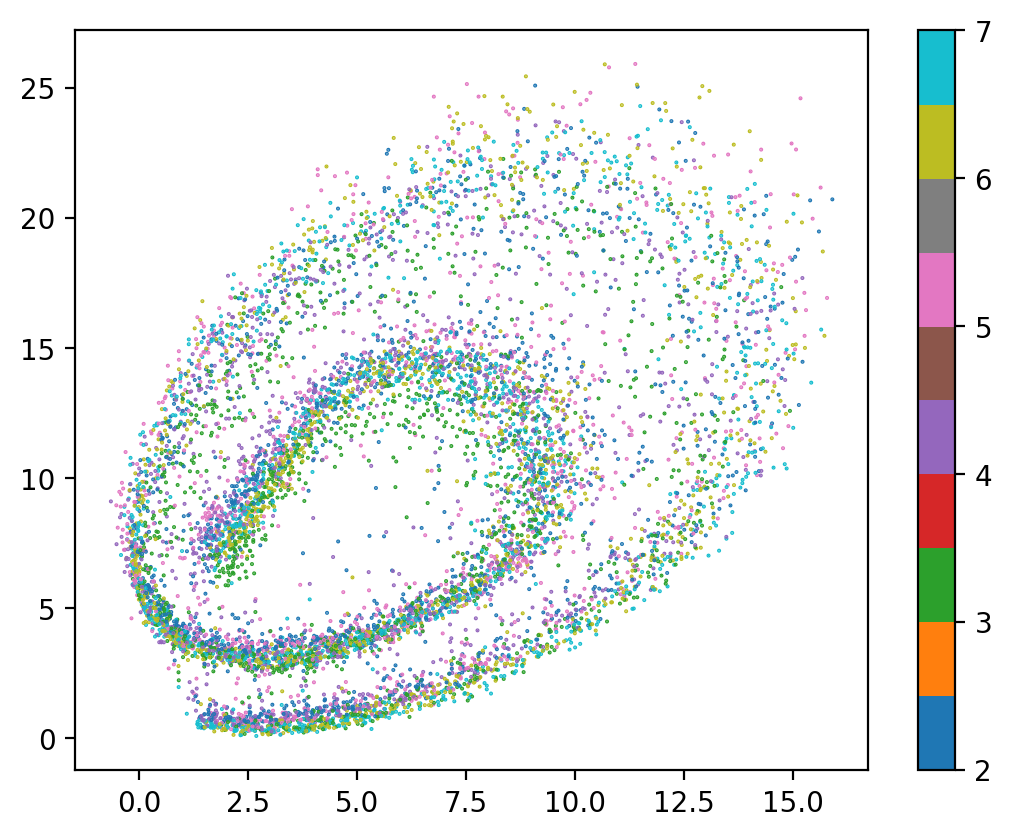

In [113]:
plt.scatter(z_y[inds,0], z_y[inds,1], c=mnist_labels[-8287:][inds].astype(int), cmap='tab10', s=.2); plt.colorbar()

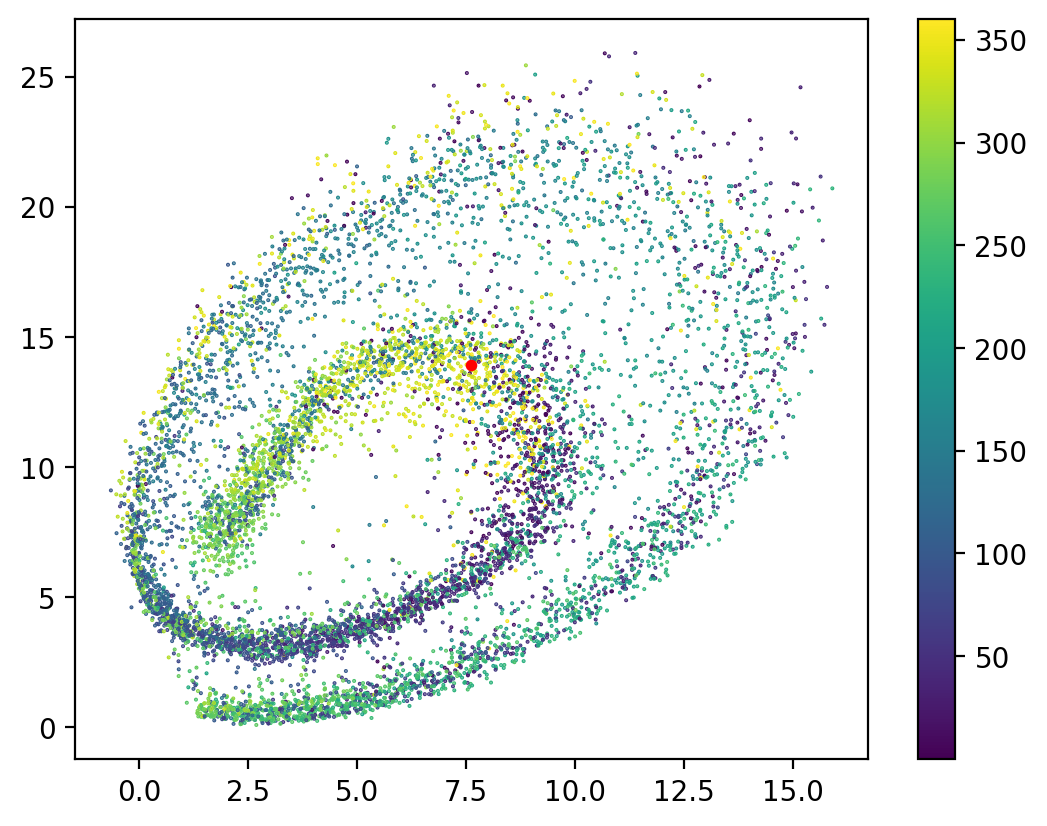

In [114]:
plt.scatter(z_y[inds,0], z_y[inds,1], c=angles[-8287:][inds], s=.2, alpha=1); plt.colorbar()
plt.scatter(z_y[5232,0], z_y[5232,1], c='r', s=10)

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(z_s_y.detach().cpu().numpy())

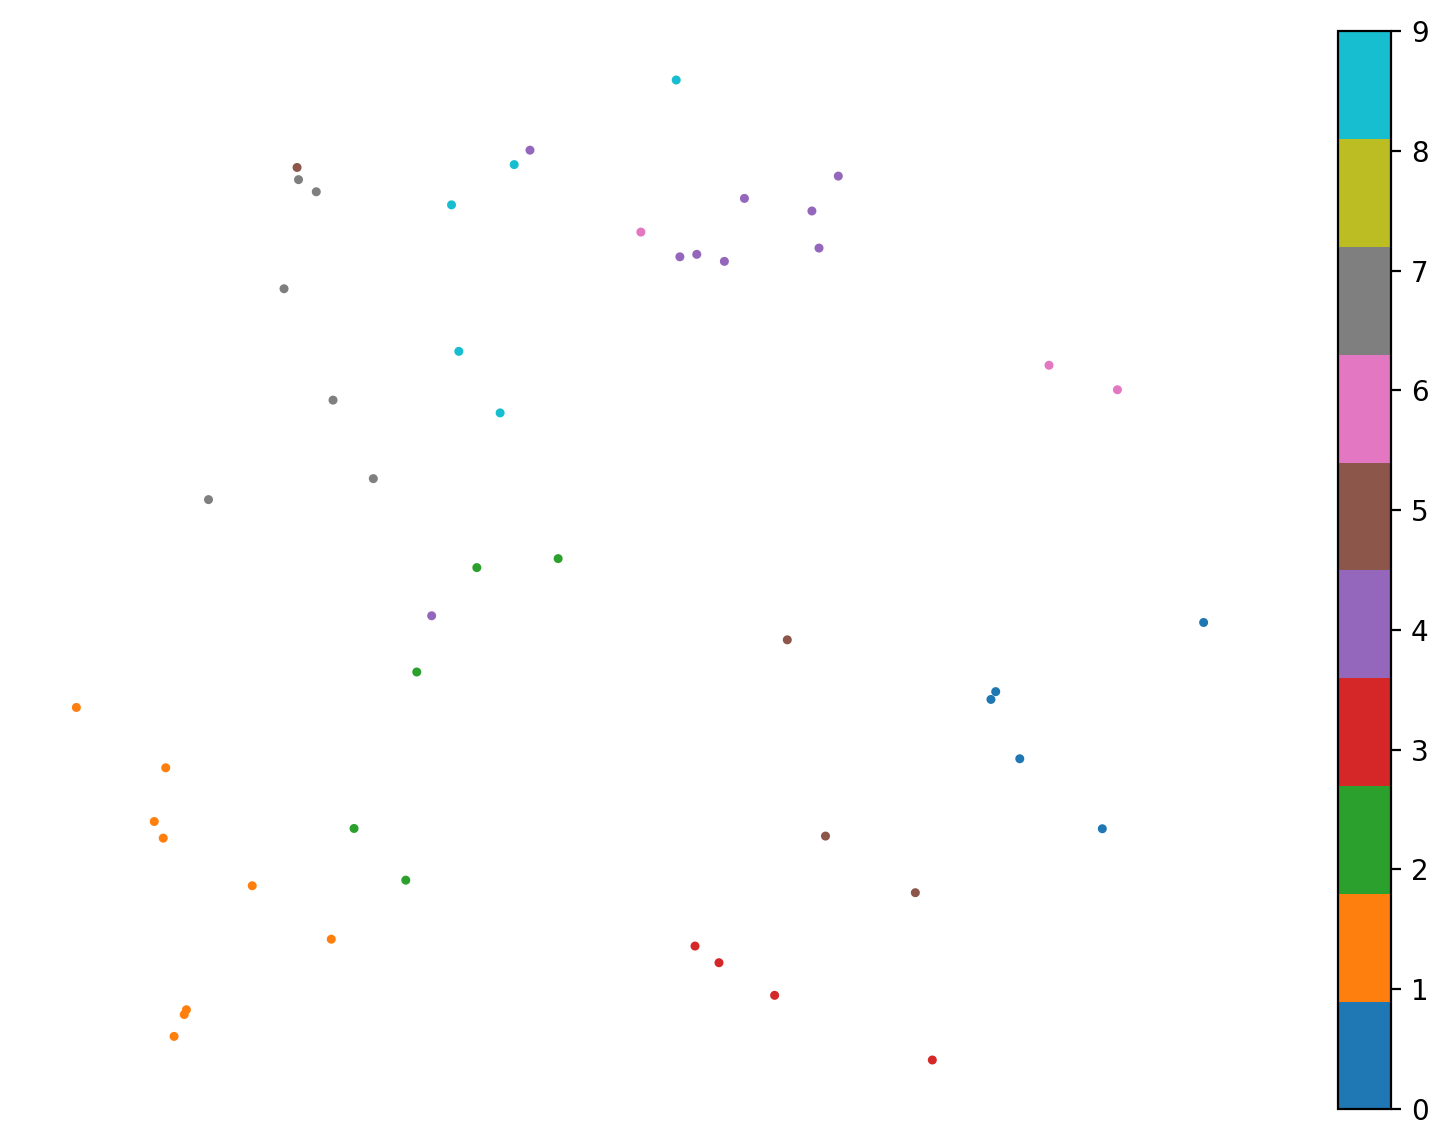

In [28]:
fig = plt.figure(figsize = (10, 7))
 
# Creating plot
plt.scatter(tsne[:50,0], tsne[:50,1],  c = mnist_labels[-10000:][:50].astype(int), s=5, cmap='tab10')
plt.axis('off'); 
plt.colorbar()
plt.savefig("figures/mnist/digit_colorbar.svg", dpi=300, transparent=True)

In [13]:
mnist_labels[15], angles[15]

('7', 303.6483)

In [164]:
z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X,Y) # type: ignore
x_in =  (z_s_y.to(device)).to(device)
y_in = torch.hstack((z_s_x.to(device), torch.ones((z_y.shape[0], 1)).to(device)*z_y[15])).to(device)

x_fix = model.source_dec(x_in) # type: ignore
y_fix = model.target_dec(y_in) # type: ignore

x_fix = x_fix.detach().cpu().numpy()
y_fix = y_fix.detach().cpu().numpy()

In [165]:
landmark_inds = np.random.choice(np.arange(33150), 100, replace=False)

In [166]:
neigh = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(x_fix[:60000])
pair_dists, neighbors = neigh.kneighbors(x_fix[:60000], return_distance=True)    # type: ignore
neighbors = neighbors[:, 1:]
pair_dists = pair_dists[:, 1:]

graph = lil_array((pair_dists.shape[0],pair_dists.shape[0]))
for i in range(pair_dists.shape[0]):
    graph[i, neighbors[i]] = pair_dists[i, :]

x_s_dists = dijkstra(graph, indices=landmark_inds, directed=False, unweighted=False)

neigh = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(y_fix[:60000])
pair_dists, neighbors = neigh.kneighbors(y_fix[:60000], return_distance=True)    # type: ignore
neighbors = neighbors[:, 1:]
pair_dists = pair_dists[:, 1:]

graph = lil_array((pair_dists.shape[0],pair_dists.shape[0]))
for i in range(pair_dists.shape[0]):
    graph[i, neighbors[i]] = pair_dists[i, :]

y_s_dists = dijkstra(graph, indices=landmark_inds, directed=False, unweighted=False)

In [145]:
(torch.ones((z_s_x.shape[0], 30)).to(device)*z_s_x[15]).shape

torch.Size([33150, 30])

In [178]:
z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X,Y) # type: ignore

y_in = torch.hstack(((torch.ones((z_s_x.shape[0], 30)).to(device) * z_s_x[15]).to(device), z_y.to(device))).to(device)

y_fix = model.target_dec(y_in) # type: ignore

y_fix = y_fix.detach().cpu().numpy()

In [191]:
y_fix_art = np.zeros((y_fix.shape[0], 28, 28))
for i in range(y_fix.shape[0]):
    y_fix_art[i] = rot_digit(mnist[15], angles[i])[0].reshape(28,28)/255

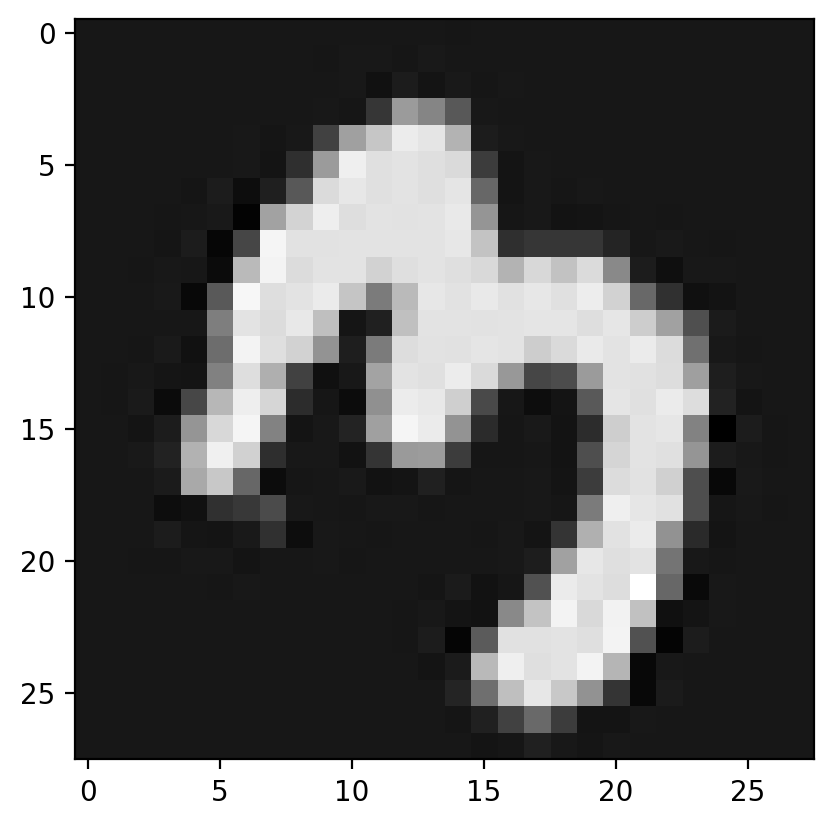

In [192]:
plt.imshow(y_fix_art[2456], cmap='gray',)

In [193]:
y_fix_art = y_fix_art.reshape(-1, 28*28)
neigh = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(y_fix_art[:60000])
pair_dists, neighbors = neigh.kneighbors(y_fix_art[:60000], return_distance=True)    # type: ignore
neighbors = neighbors[:, 1:]
pair_dists = pair_dists[:, 1:]

graph = lil_array((pair_dists.shape[0],pair_dists.shape[0]))
for i in range(pair_dists.shape[0]):
    graph[i, neighbors[i]] = pair_dists[i, :]

y_dists = dijkstra(graph, indices=landmark_inds, directed=False, unweighted=False)

In [120]:
neigh = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(y_fix[:60000])
pair_dists, neighbors = neigh.kneighbors(y_fix[:60000], return_distance=True)    # type: ignore
neighbors = neighbors[:, 1:]
pair_dists = pair_dists[:, 1:]

graph = lil_array((pair_dists.shape[0],pair_dists.shape[0]))
for i in range(pair_dists.shape[0]):
    graph[i, neighbors[i]] = pair_dists[i, :]

y_dists = dijkstra(graph, indices=landmark_inds, directed=False, unweighted=False)

In [181]:
x_s_dists = torch.Tensor(x_s_dists).to(device)
y_s_dists = torch.Tensor(y_s_dists).to(device)
y_dists = torch.Tensor(y_dists).to(device)

In [182]:
def iso_loss_func(target, out, z, dists, inds):
    loss = torch.nn.functional.mse_loss(target, out, reduction='mean')

    prox = torch.linalg.norm(dists-torch.cdist(z[inds],z))/(dists.shape[0]**2)
    return loss + torch.sqrt(prox), loss, prox   

In [183]:
lr = 0.001/25
num_epochs = 10001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = LinearLR(optimizer, total_iters=num_epochs, start_factor=1, end_factor=1/50)

msr_params = list(model.msr_source.parameters())
msr_optimizer = torch.optim.Adam(msr_params, lr=lr)
c = .5

In [184]:
X_test = (torch.Tensor(mnist[-8287:]).to(device)/255)
Y_test = (torch.Tensor(rotated_mnist[-8287:]).to(device)/255)

Y_test[Y_test > 255] = 255
Y_test[Y_test < 0] = 0

In [186]:
for epoch in range(num_epochs):
    print("EPOCH %d" % epoch, end='\r')

    if (epoch % 500 == 0):
        model.msr_source = decoder(2, nInputs, layers[::-1]).to(device)
        msr_params = list(model.msr_source.parameters())
        msr_optimizer = torch.optim.Adam(msr_params, lr=lr)
        msr_iter = 500
    else:
        msr_iter = 10

# 1) fine tune shared encoders
    for param in model.parameters():
        param.requires_grad = False
    for param in model.shared_source_enc.parameters():
        param.requires_grad = True
    for param in model.shared_target_enc.parameters():
        param.requires_grad = True
    for param in model.source_dec.parameters():
        param.requires_grad = True
    for param in model.target_dec.parameters():        
        param.requires_grad = True

    z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X, Y)
    source_loss, source_mse, source_prox = iso_loss_func(X, x_hat, z_s_x, y_s_dists, landmark_inds)
    target_loss, target_mse, target_prox = iso_loss_func(Y, y_hat, z_s_y, x_s_dists, landmark_inds)
    loss = source_loss + target_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# 2) train measurement network
    for param in model.parameters():
        param.requires_grad = False
    for param in model.msr_source.parameters():
        param.requires_grad = True  

    for i in range(msr_iter):
        z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X, Y)
        msr_loss = (
                    nInputs
                    * torch.nn.functional.mse_loss(X, m_s_x)
                    / X.detach().var(dim=0).sum()
                )

        msr_optimizer.zero_grad()
        msr_loss.backward()
        msr_optimizer.step()

# 3) fine tune private encoders
    for param in model.parameters():
        param.requires_grad = False
    for param in model.target_enc.parameters():
        param.requires_grad = True
    for param in model.target_dec.parameters():        
        param.requires_grad = True

    z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X, Y)
    target_loss, target_mse, target_prox = iso_loss_func(Y, y_hat, z_y, y_dists, landmark_inds)

    disent_loss = m_s_x.var(dim=0).sum() / X.var(dim=0).sum()
    loss = target_loss + c*disent_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X_test, Y_test)
        test_source_loss = torch.nn.functional.mse_loss(X_test, x_hat)
        test_target_loss = torch.nn.functional.mse_loss(Y_test, y_hat)
        test_msr_loss = nInputs*torch.nn.functional.mse_loss(m_s_x, X_test)/X_test.var(dim=0).sum()
        test_disent_loss = m_s_x.var(dim=0).sum() / X_test.var(dim=0).sum()

        print(
            "EPOCH %d \t source mse: %.5f | %.5f \t source prox: %.5f \t target mse: %.5f | %.5f \t target prox: %.5f \t msr: %.5f | %.5f \t disentangle: %.5f | %.5f"
            % (
                epoch,
                source_mse.item(),
                test_source_loss.item(),
                source_prox.item(),
                target_mse.item(),
                test_target_loss.item(),
                target_prox.item(),
                msr_loss.item(),
                test_msr_loss.item(),
                disent_loss.item(),
                test_disent_loss.item(),
            )
        )
        


EPOCH 0 	 source mse: 0.03061 | 0.03046 	 source prox: 1.42407 	 target mse: 0.02629 | 0.02623 	 target prox: 1.81770 	 msr: 3.68864 | 1.20076 	 disentangle: 0.17178 | 0.17289
EPOCH 100 	 source mse: 0.03172 | 0.03154 	 source prox: 0.37974 	 target mse: 0.03321 | 0.03317 	 target prox: 1.53086 	 msr: 0.68043 | 1.07061 	 disentangle: 0.06912 | 0.06986
EPOCH 200 	 source mse: 0.03123 | 0.03107 	 source prox: 0.25272 	 target mse: 0.03234 | 0.03240 	 target prox: 1.35708 	 msr: 0.64633 | 1.04767 	 disentangle: 0.04909 | 0.04923
EPOCH 300 	 source mse: 0.03104 | 0.03092 	 source prox: 0.21323 	 target mse: 0.03160 | 0.03175 	 target prox: 1.31007 	 msr: 0.62359 | 1.02290 	 disentangle: 0.02614 | 0.02620
EPOCH 400 	 source mse: 0.03091 | 0.03081 	 source prox: 0.19636 	 target mse: 0.03093 | 0.03114 	 target prox: 1.28916 	 msr: 0.61265 | 1.01100 	 disentangle: 0.01520 | 0.01531
EPOCH 500 	 source mse: 0.03080 | 0.03072 	 source prox: 0.18663 	 target mse: 0.03055 | 0.03089 	 target prox: 

KeyboardInterrupt: 

In [116]:
z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X_test, Y_test)

In [117]:
x_hat = x_hat.detach().cpu().numpy().squeeze()
y_hat = y_hat.detach().cpu().numpy().squeeze()
z_y = z_y.detach().cpu().numpy().squeeze()

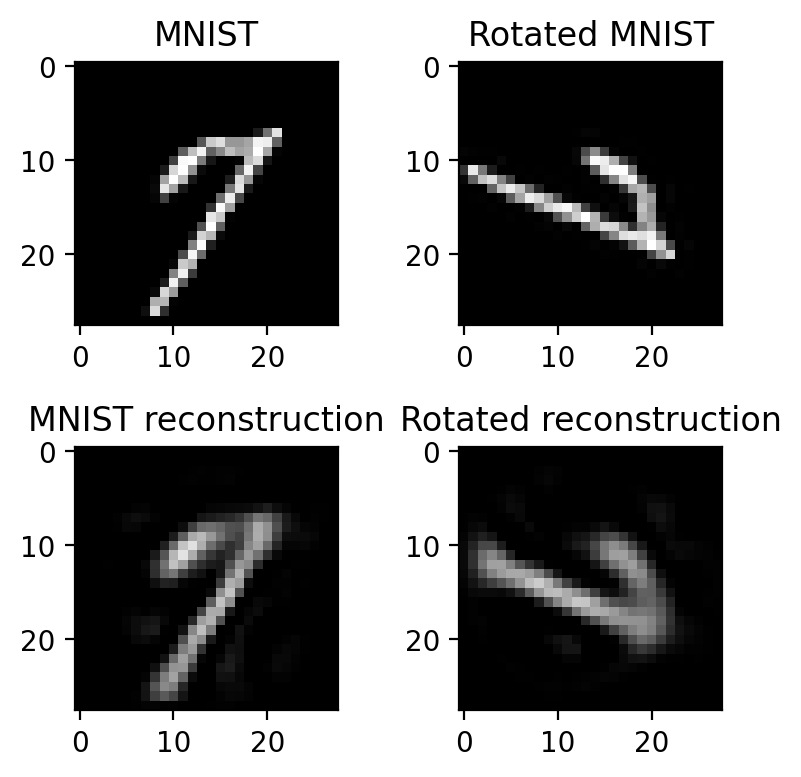

In [18]:
ind = np.random.choice(np.arange(10000), 1, replace=False)
plt.figure(figsize=(4,4))

plt.subplot(2,2,1)
plt.imshow(mnist[ind].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
plt.title("MNIST")

plt.subplot(2,2,2)
plt.imshow(rotated_mnist[ind].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
plt.title("Rotated MNIST")

plt.subplot(2,2,3)
plt.imshow(x_hat[ind].reshape(28,28), cmap='gray', vmin=0, vmax=1) 
plt.title("MNIST reconstruction")

plt.subplot(2,2,4)
plt.imshow(y_hat[ind].reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.title("Rotated reconstruction"); 

plt.tight_layout()

In [19]:
ind = 2230

test_rot_lat = torch.hstack((z_s_x[ind,:], z_y[-7]))
test_rot = model.target_dec(test_rot_lat).detach().cpu().numpy().reshape(28,28)

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(mnist[-10000:][ind].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
plt.title("Unrotated Digit")

# plt.subplot(1,4,2)
# plt.imshow(rotated_mnist[ind].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
# plt.title("Train Rotated Digit")

plt.subplot(1,3,3)
plt.imshow(test_rot, cmap='gray', vmin=0, vmax=1)
plt.title("Interpolated Rotated Digit")

plt.subplot(1,3,2)
plt.imshow(rotated_mnist[-10000:][-7].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
plt.title("Rotation Angle Source");
plt.tight_layout()

TypeError: expected Tensor as element 1 in argument 0, but got numpy.ndarray

In [198]:
angles_1 = [0, 72, 144, 216, 288]
angles_2 = [36, 108, 180, 252, 324]

inds_1 = []
inds_2 = []

bad = ['0', '6', '5']

for ang in angles_1:
    ind = 1
    argsort = np.argsort(np.abs(angles[60000:] - ang))
    while mnist_labels[-10000:][argsort[ind]] in bad:
        print("bad %s" % mnist_labels[-10000:][argsort[ind]])
        ind += 1
    print(mnist_labels[-10000:][argsort[ind]])
    inds_1.append(argsort[ind])

for ang in angles_2:
    ind = 0
    argsort = np.argsort(np.abs(angles[60000:] - ang))
    while mnist_labels[-10000:][argsort[ind]] in bad:
        print("bad %s" % mnist_labels[-10000:][argsort[ind]])
        ind += 1
    print(mnist_labels[-10000:][argsort[ind]])
    inds_2.append(np.argsort(np.abs(angles[60000:] - ang))[ind])

3
1
bad 0
9
2
3
bad 5
7
bad 0
3
3
8
1


In [195]:
inds_2

[2275, 7010, 1738, 5589, 4232]

In [89]:
inds_1, inds_2

([3906, 8192, 6119, 2421, 8844], [8208, 9530, 1315, 8438, 5717])

In [92]:
angles[-10000:][inds_1]

NameError: name 'inds_1' is not defined

In [118]:
inds = np.arange(10000)

# inds_1 = [5960, 9094,   90, 5430,  642]
# inds_2 = [7863, 1564, 3615, 7056, 6942]
# inds_3 = [3467, 9030, 5286,  573, 8304]
# inds_4 = [4198, 7193, 8593, 8989, 5862]

blues = ["#03254c", "#1167b1", "#187bcd", "#2a9df4", "#d0efff",]
reds = ["#c61a09", "#ed3419", "#ff4122", "#ff8164", "#ffc9bb"]
# greens = ["#99e89d", "#73c883", "#4da768", "#26874e", "#006633"]
# purples = ["#651fff", "#7c40ff", "#9b6dff", "#b99aff", "#d8c7ff"]

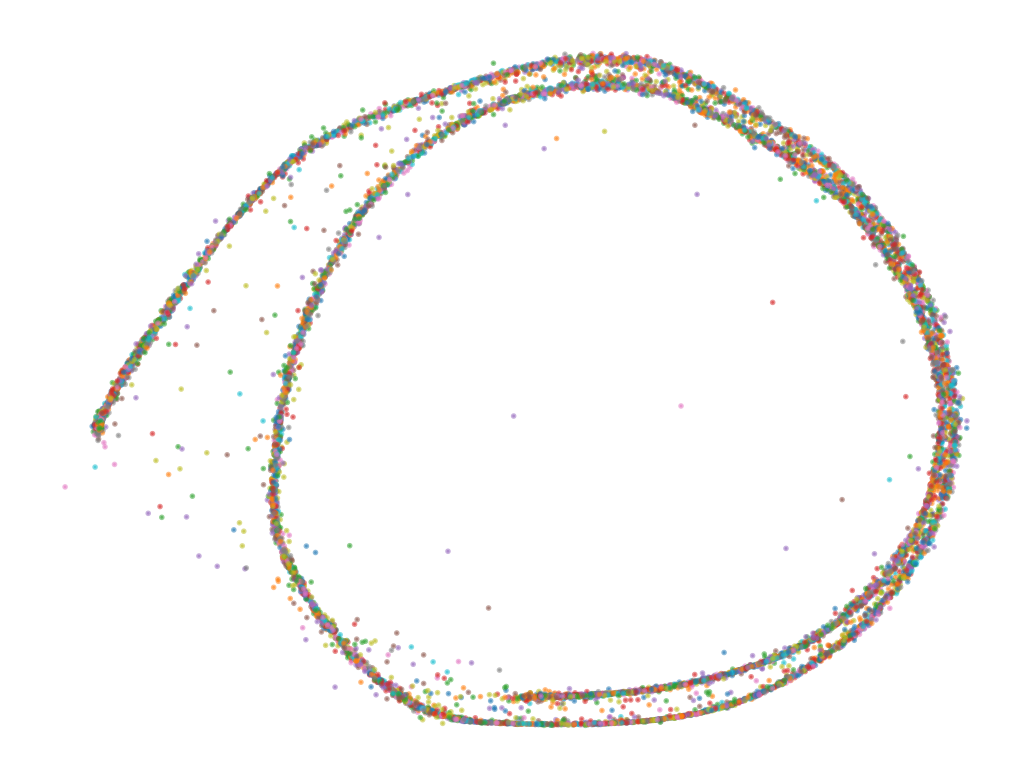

In [132]:
plt.scatter(z_y[inds,0], z_y[inds,1], c=mnist_labels[-10000:][inds].astype(int), cmap='tab10', s=1, alpha=.5); 
#plt.colorbar()
# plt.xlim(-1.0461036562919617, 24.478308141231537);
# plt.ylim(-2.339510774612427, 18.666875696182252);
plt.axis('off')
plt.savefig("mnist_isomap_zy_digit.png", dpi=300, transparent=True)

In [122]:
z_y_inset = z_y_inset.detach().cpu().numpy()    

In [120]:
inds_1 = [3045, 9395, 8557, 7359, 4657]
inds_2 = [2275, 7010, 1738, 5589, 4232]

((-0.9743800759315491, 38.19904834032059),
 (-2.581743294000626, 27.702863150835036))

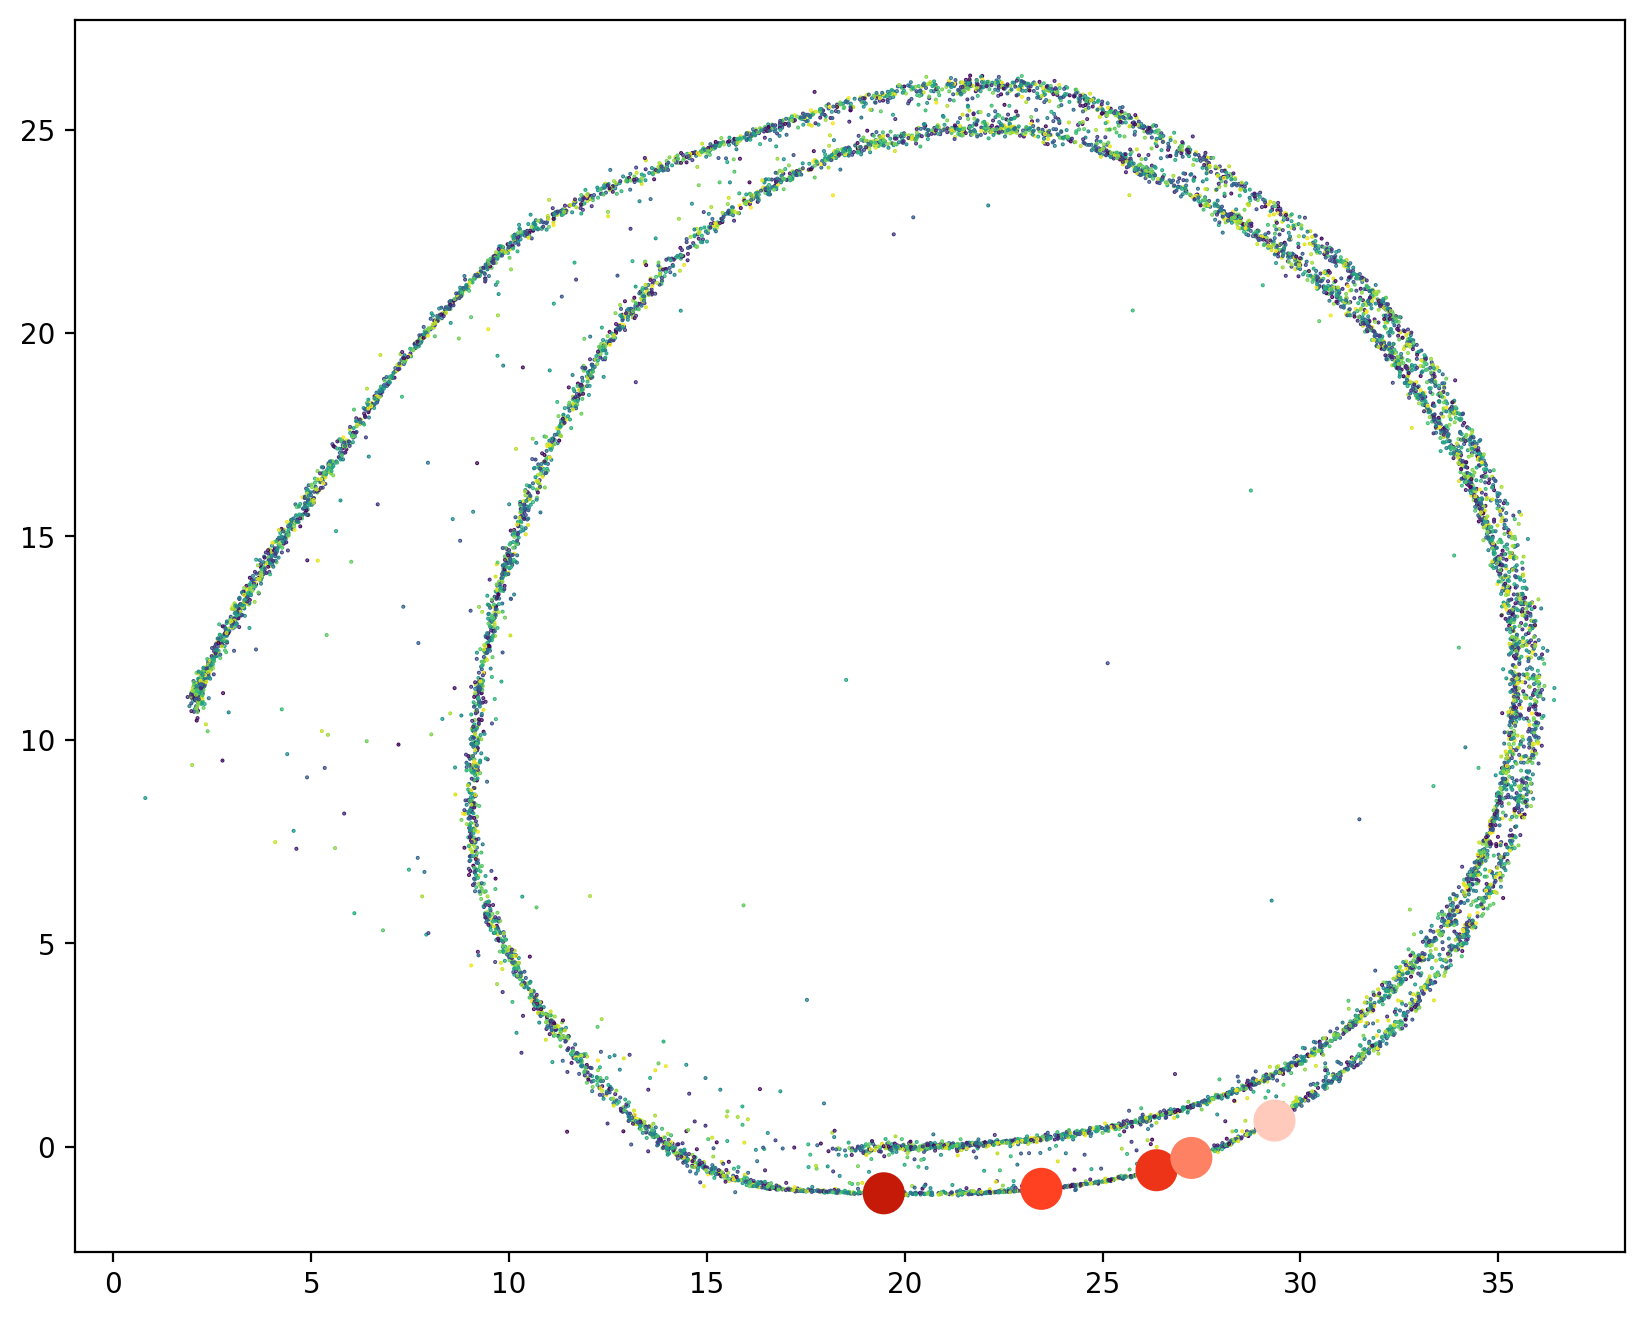

In [131]:
plt.figure(figsize=(10,8))
plt.scatter(z_y[inds,0], z_y[inds,1], c=angles[-10000:][inds], s=.2, alpha=1)
plt.scatter(z_y_inset[:,0], z_y_inset[:,1], c=reds, s=200)
# plt.scatter(z_y[inds_1,0], z_y[inds_1,1], c=blues, s=50)
# plt.scatter(z_y[inds_2,0], z_y[inds_2,1], c=reds, s=50)
# plt.scatter(z_y[inds_3,0], z_y[inds_3,1], c=greens, s=50)
# plt.scatter(z_y[inds_4,0], z_y[inds_4,1], c=purples, s=50)
# plt.xlim(0.2219733238220214, 38.43063554763794);
# plt.ylim(-2.610826647281647, 27.871639168262483);
# plt.axis('off'); 
# plt.colorbar()
# plt.savefig("figures/mnist/mnist_isomap_zy_angle.png", dpi=300, transparent=True)

plt.xlim((-0.9743800759315491, 38.19904834032059)), plt.ylim((-2.581743294000626, 27.702863150835036))
# plt.savefig("figures/mnist/mnist_inset_zy_markers.svg", dpi=300, transparent=True)

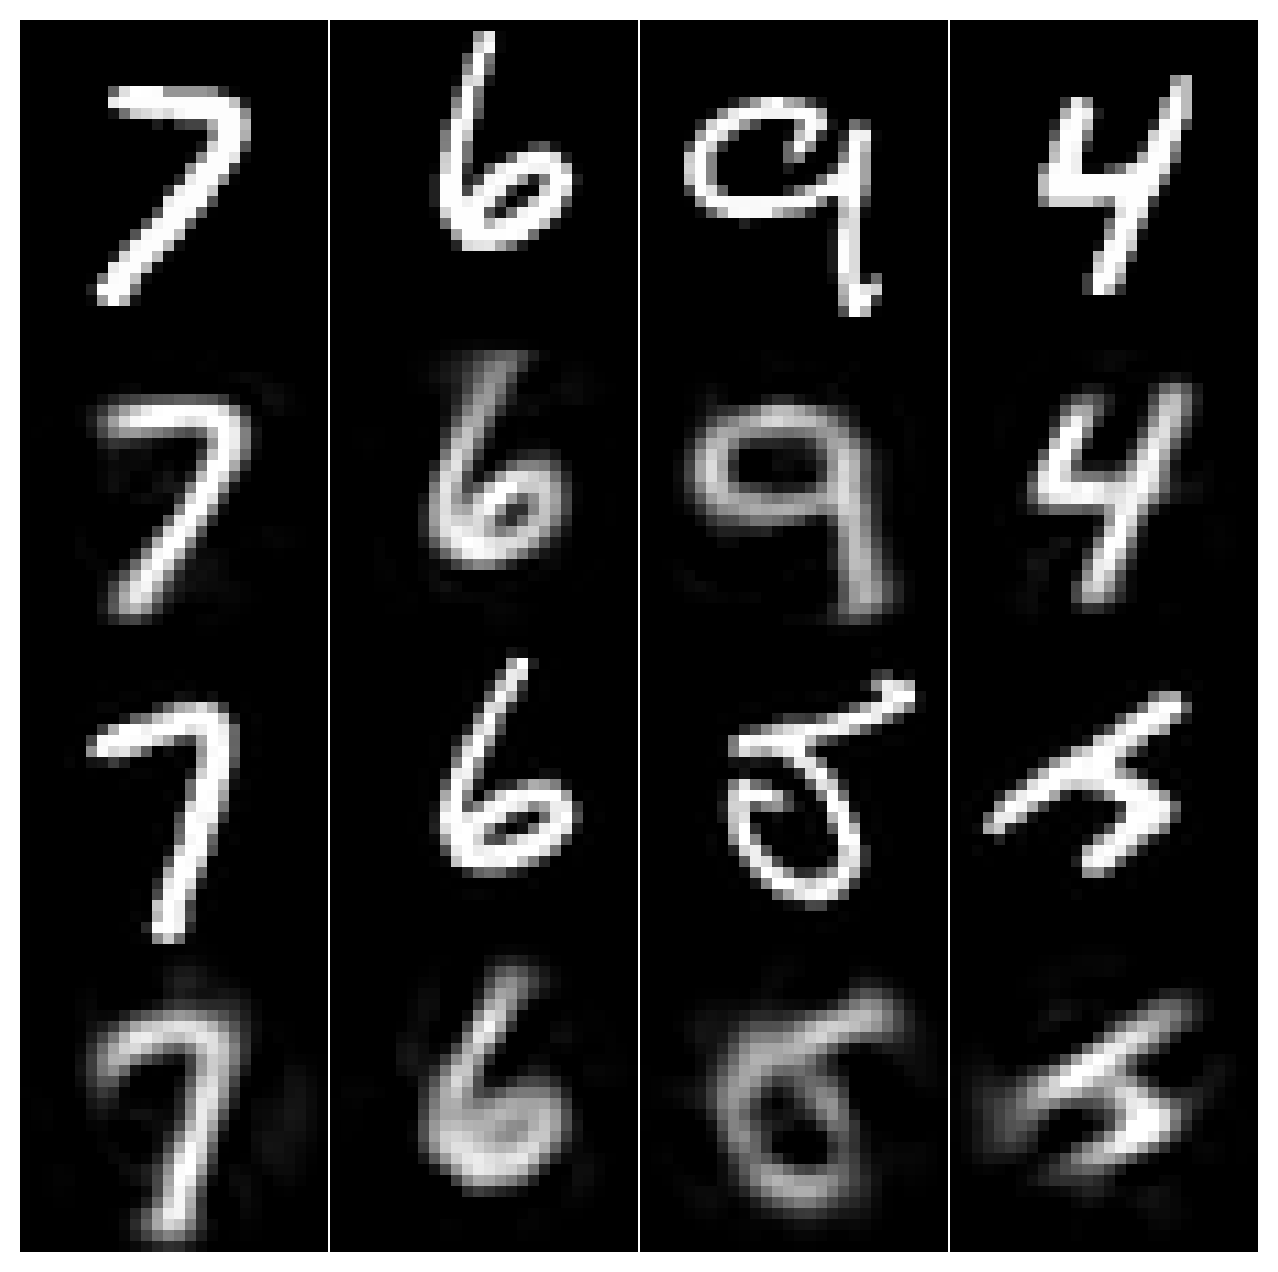

In [53]:
# inds = np.random.choice(np.arange(10000), 4, replace=False)
inds = [8885, 9355, 3385, 9987]

# f, axarr = plt.subplots(4, 4, gridspec_kw = {'wspace':0, 'hspace':0})
fig = plt.figure(figsize=(8,8)) # Notice the equal aspect ratio
axarr = [fig.add_subplot(4,4,i+1) for i in range(16)]

for i in range(4):
    ax = axarr[i]
    ax.imshow(mnist[-10000:][inds[i]].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_aspect('equal')

    ax = axarr[8+i]
    ax.imshow(rotated_mnist[-10000:][inds[i]].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_aspect('equal')

    ax = axarr[4+i]
    ax.imshow(x_hat[inds[i]].reshape(28,28), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_aspect('equal')

    ax = axarr[12+i]
    ax.imshow(y_hat[inds[i]].reshape(28,28), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_aspect('equal')


fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig("mnist_isomap_alt.svg", dpi=300, transparent=True)


In [133]:
inds

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [134]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(z_s_y.detach().cpu().numpy())

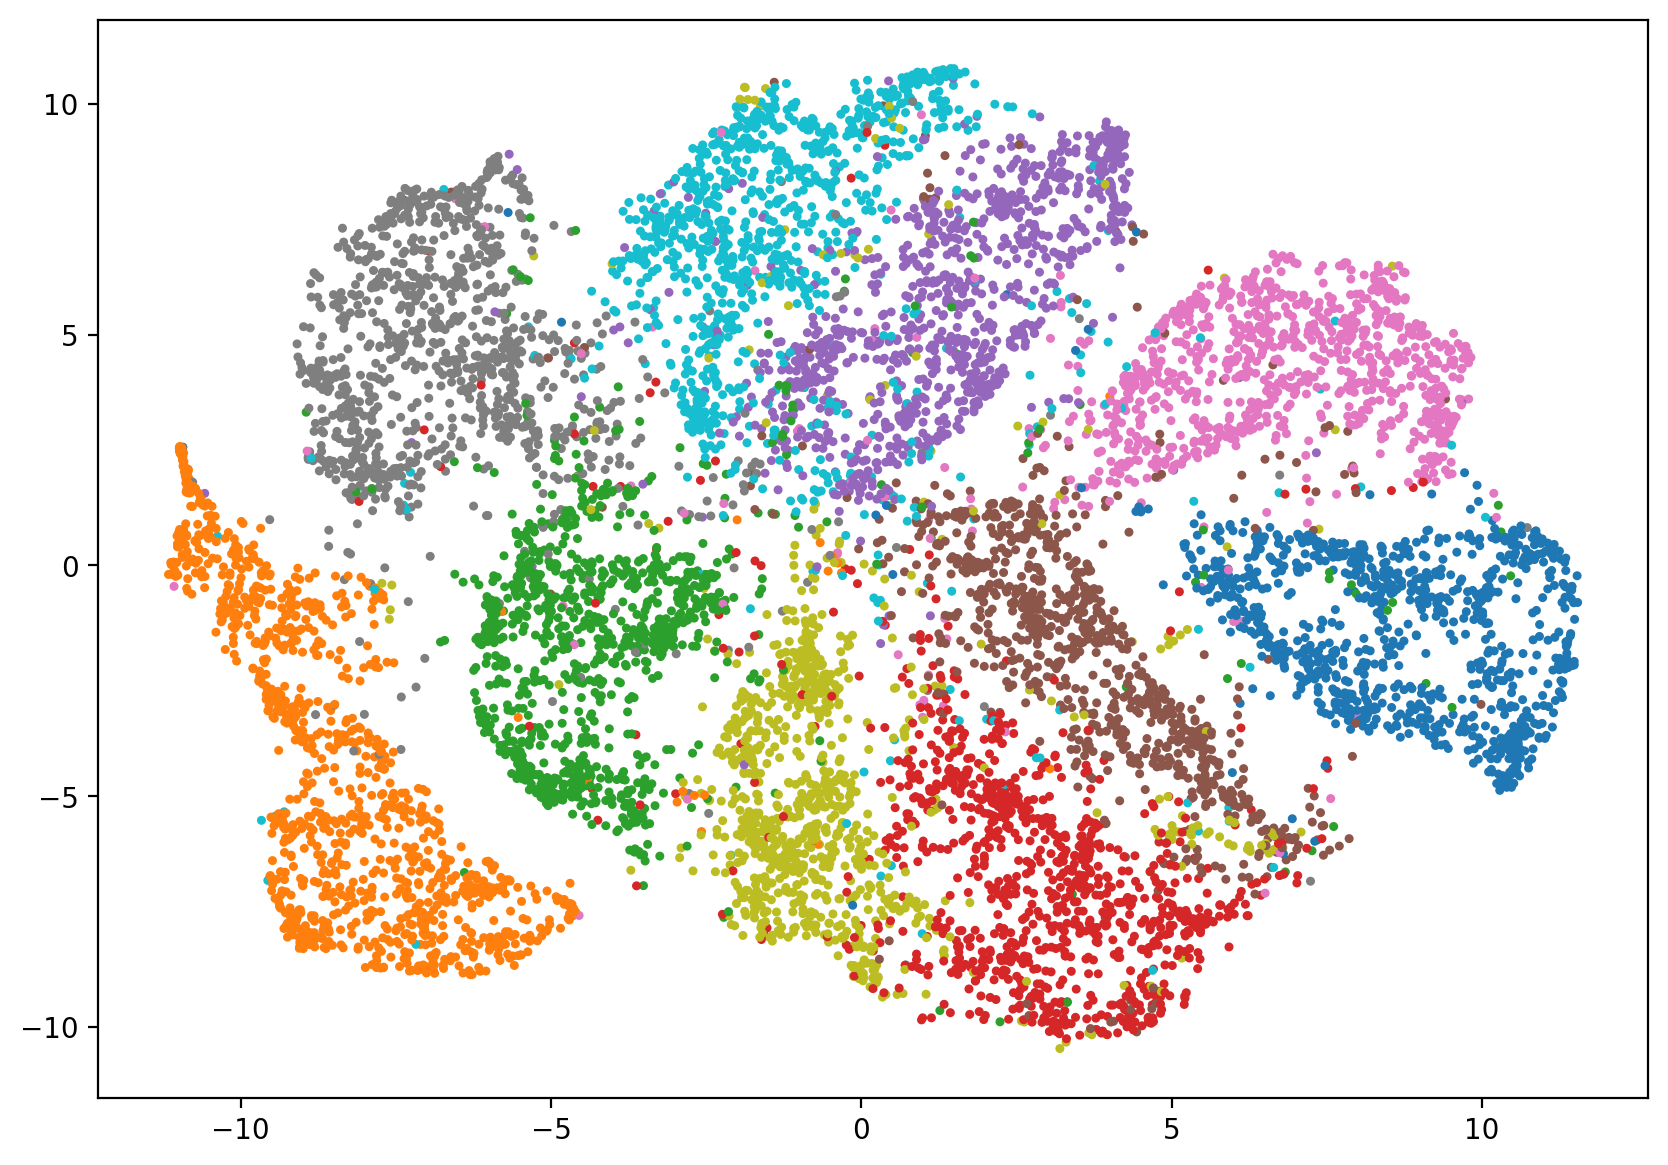

In [135]:
fig = plt.figure(figsize = (10, 7))
 
# Creating plot
plt.scatter(tsne[:,0], tsne[:,1],  c = mnist_labels[-10000:].astype(int), s=5, cmap='tab10')
plt.savefig("mnist_zsy_tsne.svg", dpi=300, transparent=True)

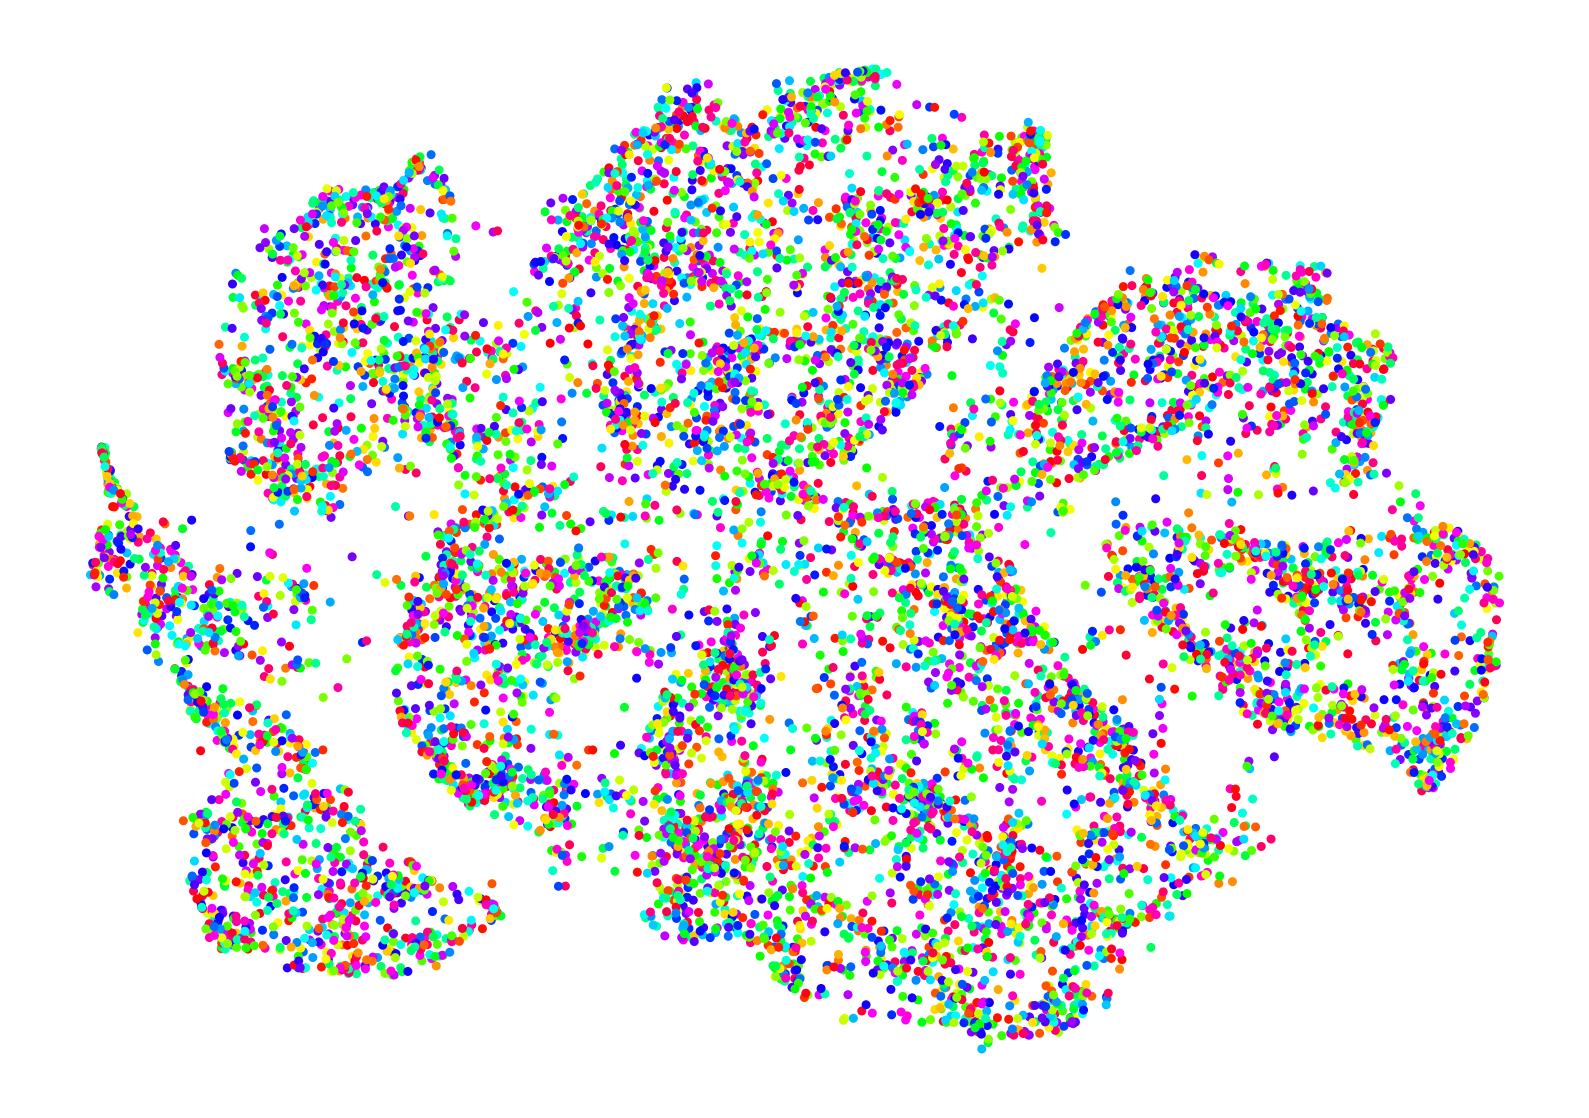

In [137]:
fig = plt.figure(figsize = (10, 7))
 
# Creating plot
plt.scatter(tsne[:,0], tsne[:,1],  c = angles[-10000:].astype(int), s=5, cmap='hsv')
plt.axis("off")
plt.savefig("mnist_zsy_tsne_angle.png", dpi=300, transparent=True)


In [31]:
test_angles = angles[:60000]

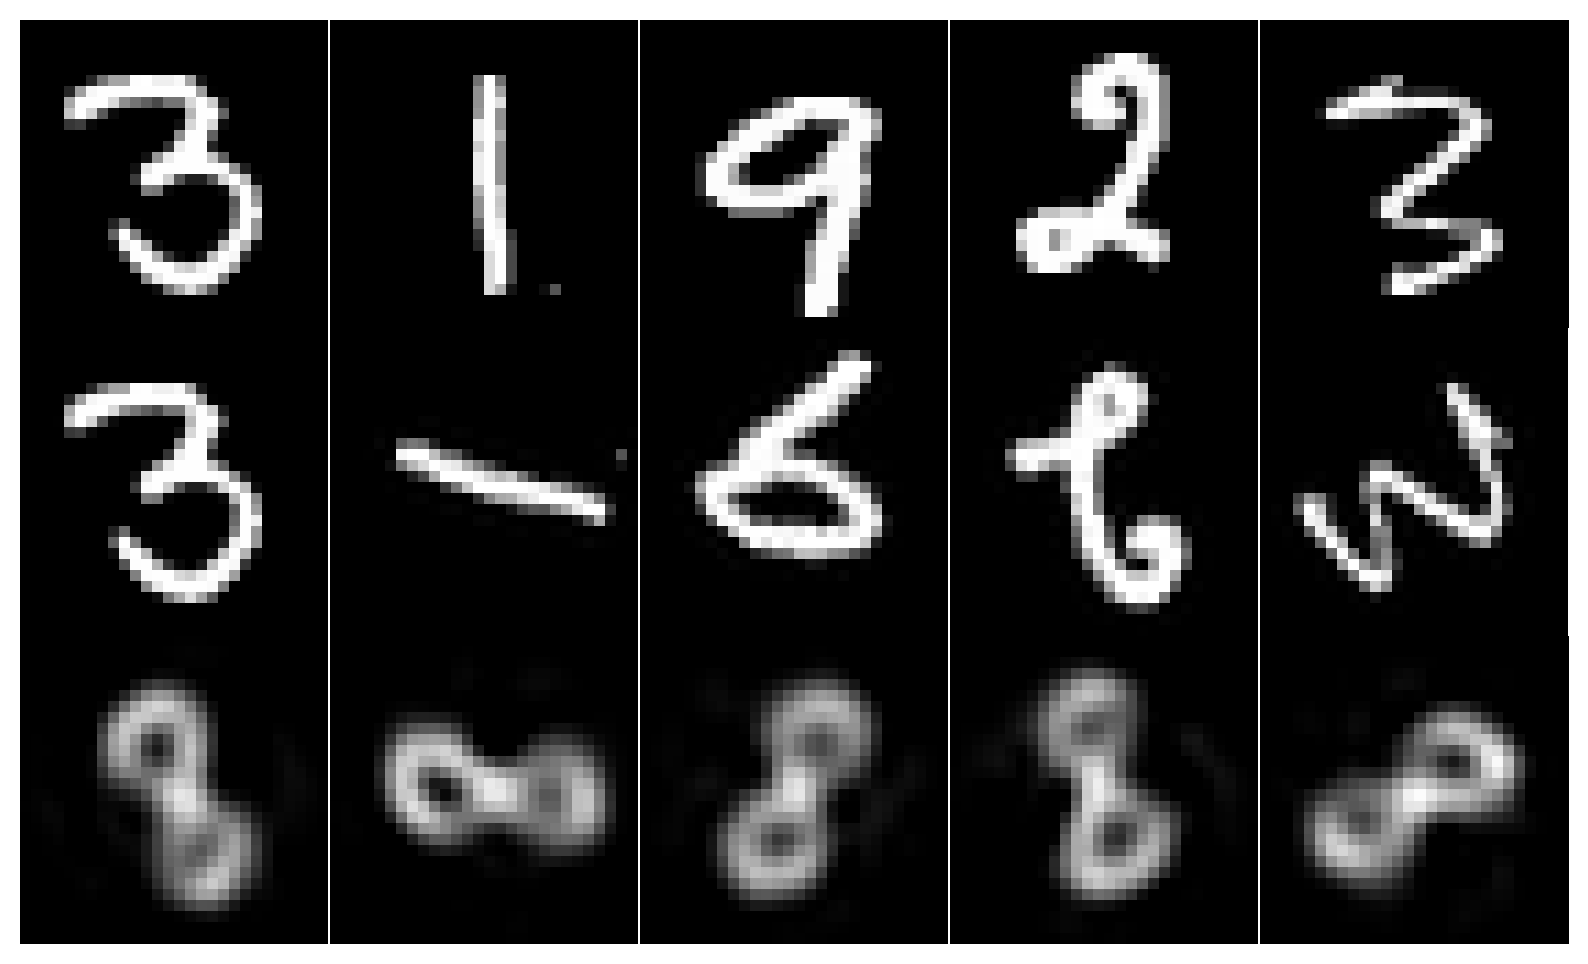

In [210]:
ind = np.random.choice(np.arange(10000), 1, replace=False) 
ind= 4251
z_s_x, z_s_y, z_y, m_s_x, x_hat, y_hat = model(X_test, Y_test)
inds = inds_1
# inds = [4419, 7813, 8831, 6097, 2232]

test_rot_lat = torch.hstack((z_s_x[ind,:] * torch.ones((5, 30)).to(device), z_y[inds, :]))
test_rot = model.target_dec(test_rot_lat).detach().cpu().numpy().reshape(-1, 28,28)

fig = plt.figure(figsize=(10,6)) # Notice the equal aspect ratio
axarr = [fig.add_subplot(3,5,i+1) for i in range(15)]

for i in range(5):
    ax = axarr[i+10]
    ax.imshow(test_rot[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

    ax = axarr[i+5]
    ax.imshow(rotated_mnist[-10000:][inds[i]].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

    ax = axarr[i]
    ax.imshow(mnist[-10000:][inds[i]].reshape(28,28)/255, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')


fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/mnist/mnist_isomap_rotated_1.svg", dpi=300, transparent=True)

In [209]:
ind

array([4251])

In [208]:
inds_1

[3045, 9395, 8557, 7359, 4657]

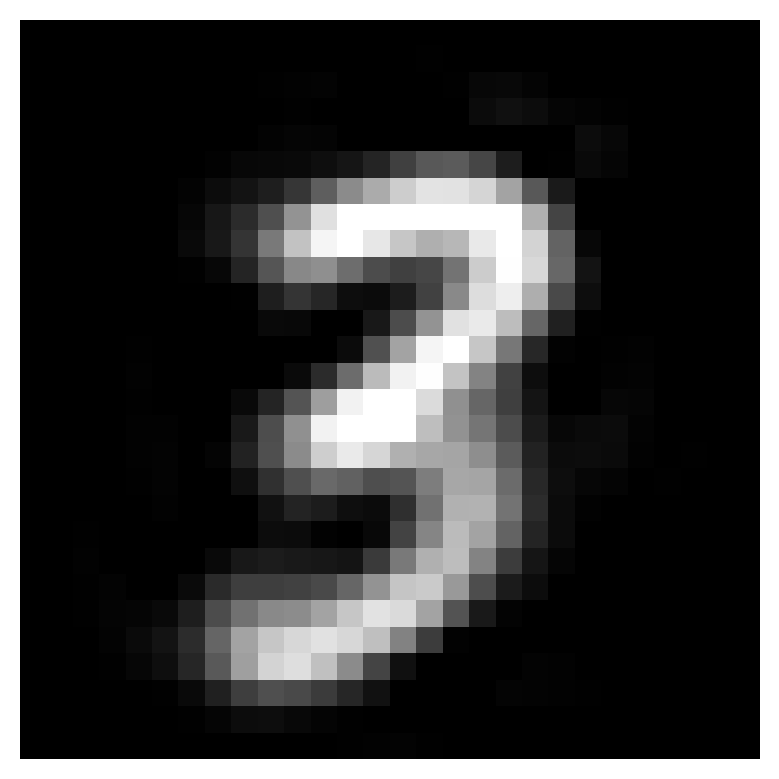

In [14]:
plt.imshow(x_hat[-10000:][7010].reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.savefig("figures/mnist/mnist_isomap_graphic_unrot_rec.svg", dpi=300, transparent=True)

In [141]:
ind

array([2463])

In [65]:
inds_1

[4419, 7813, 8831, 1398, 2232]

In [66]:
np.argsort(np.abs(angles[60000:] - angles_1[3]))

array([2421, 1398, 6097, ..., 1517, 4419, 3906])

In [56]:
angles[inds_1]

array([212.13774 ,  41.233444, 241.95831 , 148.2019  ,  37.16921 ],
      dtype=float32)

In [88]:
ind

array([9682])